# Programming Exercise 4:  Neural Networks Learning

## Introduction

In this exercise, you will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.


All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook. The assignment can be promptly submitted to the coursera grader directly from this notebook (code and instructions are included below).

Before we begin with the exercises, we need to import all libraries required for this programming exercise. Throughout the course, we will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, [`matplotlib`](https://matplotlib.org/) for plotting, and [`scipy`](https://docs.scipy.org/doc/scipy/reference/) for scientific and numerical computation functions and tools. You can find instructions on how to install required libraries in the README file in the [github repository](https://github.com/dibgerge/ml-coursera-python-assignments).

In [44]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import utils
from utils import sigmoid
# define the submission/grader object for this exercise
grader = utils.Grader()

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## Submission and Grading


After completing each part of the assignment, be sure to submit your solutions to the grader. The following is a breakdown of how each part of this exercise is scored.


| Section | Part                                             | Submission function | Points 
| :-      |:-                                                | :-                  | :-:    
| 1       | [Feedforward and Cost Function](#section1)                    | [`nnCostFunction`](#nnCostFunction)   | 30     
| 2       | [Regularized Cost Function](#section2)                        | [`nnCostFunction`](#nnCostFunction)   | 15     
| 3       | [Sigmoid Gradient](#section3)                                 | [`sigmoidGradient`](#sigmoidGradient) | 5      
| 4       | [Neural Net Gradient Function (Backpropagation)](#section4)   | [`nnCostFunction`](#nnCostFunction)   | 40     
| 5       | [Regularized Gradient](#section5)                             | [`nnCostFunction`](#nnCostFunction)   |10     
|         | Total Points                                     |    | 100    


You are allowed to submit your solutions multiple times, and we will take only the highest score into consideration.

<div class="alert alert-block alert-warning">
At the end of each section in this notebook, we have a cell which contains code for submitting the solutions thus far to the grader. Execute the cell to see your score up to the current section. For all your work to be submitted properly, you must execute those cells at least once.
</div>

## Neural Networks

In the previous exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we provided. In this exercise, you will implement the backpropagation algorithm to learn the parameters for the neural network.

We start the exercise by first loading the dataset. 

In [38]:
#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex4data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

# Number of training examples
m = y.size

### 1.1 Visualizing the data

You will begin by visualizing a subset of the training set, using the function `displayData`, which is the same function we used in Exercise 3. It is provided in the `utils.py` file for this assignment as well. The dataset is also the same one you used in the previous exercise.

There are 5000 training examples in `ex4data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each
of these training examples becomes a single row in our data matrix $X$. This gives us a 5000 by 400 matrix $X$ where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \left(x^{(1)} \right)^T - \\
- \left(x^{(2)} \right)^T - \\
\vdots \\
- \left(x^{(m)} \right)^T - \\
\end{bmatrix}
$$

The second part of the training set is a 5000-dimensional vector `y` that contains labels for the training set. 
The following cell randomly selects 100 images from the dataset and plots them.

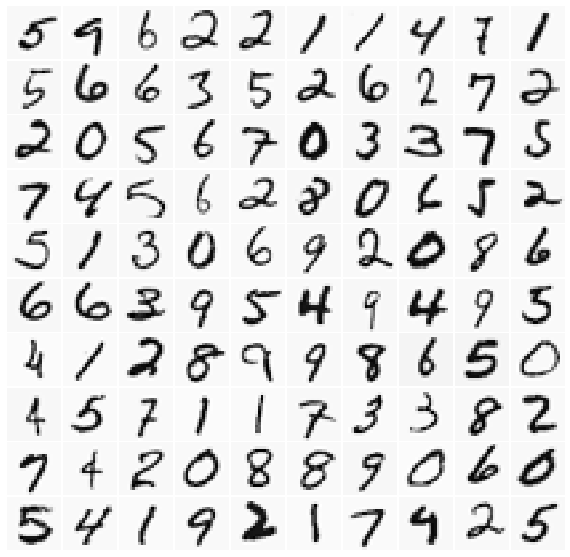

In [39]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

### 1.2 Model representation

Our neural network is shown in the following figure.

![](Figures/neural_network.png)

It has 3 layers - an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values
of digit images. Since the images are of size $20 \times 20$, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1). The training data was loaded into the variables `X` and `y` above.

You have been provided with a set of network parameters ($\Theta^{(1)}, \Theta^{(2)}$) already trained by us. These are stored in `ex4weights.mat` and will be loaded in the next cell of this notebook into `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [272]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the weights into variables Theta1 and Theta2
weights = loadmat(os.path.join('Data', 'ex4weights.mat'))

# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

# Unroll parameters 
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

<a id="section1"></a>
### 1.3 Feedforward and cost function

Now you will implement the cost function and gradient for the neural network. First, complete the code for the function `nnCostFunction` in the next cell to return the cost.

Recall that the cost function for the neural network (without regularization) is:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$

where $h_\theta \left( x^{(i)} \right)$ is computed as shown in the neural network figure above, and K = 10 is the total number of possible labels. Note that $h_\theta(x^{(i)})_k = a_k^{(3)}$ is the activation (output
value) of the $k^{th}$ output unit. Also, recall that whereas the original labels (in the variable y) were 0, 1, ..., 9, for the purpose of training a neural network, we need to encode the labels as vectors containing only values 0 or 1, so that

$$ y = 
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{or} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5 = 1$, and the other elements equal to 0.

You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example $i$ and sum the cost over all examples. **Your code should also work for a dataset of any size, with any number of labels** (you can assume that there are always at least $K \ge 3$ labels).

<div class="alert alert-box alert-warning">
**Implementation Note:** The matrix $X$ contains the examples in rows (i.e., X[i,:] is the i-th training example $x^{(i)}$, expressed as a $n \times 1$ vector.) When you complete the code in `nnCostFunction`, you will need to add the column of 1’s to the X matrix. The parameters for each unit in the neural network is represented in Theta1 and Theta2 as one row. Specifically, the first row of Theta1 corresponds to the first hidden unit in the second layer. You can use a for-loop over the examples to compute the cost.
</div>
<a id="nnCostFunction"></a>

In [275]:
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):
    """
    Implements the neural network cost function and gradient for a two layer neural 
    network which performs classification. 
    
    Parameters
    ----------
    nn_params : array_like
        The parameters for the neural network which are "unrolled" into 
        a vector. This needs to be converted back into the weight matrices Theta1
        and Theta2.
    
    input_layer_size : int
        Number of features for the input layer. 
    
    hidden_layer_size : int
        Number of hidden units in the second layer.
    
    num_labels : int
        Total number of labels, or equivalently number of units in output layer. 
    
    X : array_like
        Input dataset. A matrix of shape (m x input_layer_size).
    
    y : array_like
        Dataset labels. A vector of shape (m,).
    
    lambda_ : float, optional
        Regularization parameter.
 
    Returns
    -------
    J : float
        The computed value for the cost function at the current weight values.
    
    grad : array_like
        An "unrolled" vector of the partial derivatives of the concatenatation of
        neural network weights Theta1 and Theta2.
    
    Instructions
    ------------
    You should complete the code by working through the following parts.
    
    - Part 1: Feedforward the neural network and return the cost in the 
              variable J. After implementing Part 1, you can verify that your
              cost function computation is correct by verifying the cost
              computed in the following cell.
    
    - Part 2: Implement the backpropagation algorithm to compute the gradients
              Theta1_grad and Theta2_grad. You should return the partial derivatives of
              the cost function with respect to Theta1 and Theta2 in Theta1_grad and
              Theta2_grad, respectively. After implementing Part 2, you can check
              that your implementation is correct by running checkNNGradients provided
              in the utils.py module.
    
              Note: The vector y passed into the function is a vector of labels
                    containing values from 0..K-1. You need to map this vector into a 
                    binary vector of 1's and 0's to be used with the neural network
                    cost function.
     
              Hint: We recommend implementing backpropagation using a for-loop
                    over the training examples if you are implementing it for the 
                    first time.
    
    - Part 3: Implement regularization with the cost function and gradients.
    
              Hint: You can implement this around the code for
                    backpropagation. That is, you can compute the gradients for
                    the regularization separately and then add them to Theta1_grad
                    and Theta2_grad from Part 2.
    
    Note 
    ----
    We have provided an implementation for the sigmoid function in the file 
    `utils.py` accompanying this assignment.
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    # Setup some useful variables
    m = y.size
         
    # You need to return the following variables correctly 
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)

    # ====================== YOUR CODE HERE ======================
    # 1-hot encode y 
    y = np.eye(y.max()+1)[y]
    
    y1 = np.ravel(y)
    h = np.ravel(sigmoid(np.concatenate([np.ones((m, 1)), sigmoid(np.concatenate([np.ones((m, 1)), X], axis=1)@np.transpose(Theta1))], axis=1)@np.transpose(Theta2)))
    
    J = (y1@np.log(h) + (1-y1)@np.log(1-h)) /-m + lambda_/2/m*(np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    
    for i in range(m):
        a1 = np.insert(X[i], 0, 1, axis=0)
        a2 = np.insert(sigmoid(a1@np.transpose(Theta1)), 0, 1, axis=0)
        a3 = sigmoid(a2@np.transpose(Theta2))
        delta3 = a3-y[i]
        delta2 = (np.transpose(Theta2)@delta3 * a2 * (1-a2))[1:]
        Theta2_grad += np.outer(delta3,a2)
        Theta1_grad += np.outer(delta2,a1)
    Theta1[:,0] = 0 
    Theta2[:,0] = 0
    Theta1_grad += lambda_*Theta1
    Theta2_grad += lambda_*Theta2
    # ================================================================
    # Unroll gradients
    # grad = np.concatenate([Theta1_grad.ravel(order=order), Theta2_grad.ravel(order=order)])
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])/m
 
    return J, grad

lambda_ = 3
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lambda_)

<div class="alert alert-box alert-warning">
Use the following links to go back to the different parts of this exercise that require to modify the function `nnCostFunction`.<br>

Back to:
- [Feedforward and cost function](#section1)
- [Regularized cost](#section2)
- [Neural Network Gradient (Backpropagation)](#section4)
- [Regularized Gradient](#section5)
</div>

<a id="section5"></a>
### 2.5 Regularized Neural Network

After you have successfully implemented the backpropagation algorithm, you will add regularization to the gradient. To account for regularization, it turns out that you can add this as an additional term *after* computing the gradients using backpropagation.

Specifically, after you have computed $\Delta_{ij}^{(l)}$ using backpropagation, you should add regularization using

$$ \begin{align} 
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} & \qquad \text{for } j = 0 \\
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} + \frac{\lambda}{m} \Theta_{ij}^{(l)} & \qquad \text{for } j \ge 1
\end{align}
$$

Note that you should *not* be regularizing the first column of $\Theta^{(l)}$ which is used for the bias term. Furthermore, in the parameters $\Theta_{ij}^{(l)}$, $i$ is indexed starting from 1, and $j$ is indexed starting from 0. Thus, 

$$
\Theta^{(l)} = \begin{bmatrix}
\Theta_{1,0}^{(i)} & \Theta_{1,1}^{(l)} & \cdots \\
\Theta_{2,0}^{(i)} & \Theta_{2,1}^{(l)} & \cdots \\
\vdots &  ~ & \ddots
\end{bmatrix}
$$

[Now modify your code that computes grad in `nnCostFunction` to account for regularization.](#nnCostFunction)

After you are done, the following cell runs gradient checking on your implementation. If your code is correct, you should expect to see a relative difference that is less than 1e-9.

In [276]:
#  Check gradients by running checkNNGradients
lambda_ = 3
utils.checkNNGradients(nnCostFunction, lambda_)

# Also output the costFunction debugging values
debug_J, _  = nnCostFunction(nn_params, input_layer_size,
                          hidden_layer_size, num_labels, X, y, lambda_)

print('\n\nCost at (fixed) debugging parameters (w/ lambda = %f): %f ' % (lambda_, debug_J))
print('(for lambda = 3, this value should be about 0.576051)')

[[-8.32514572e-03 -9.27825236e-03]
 [-1.67643724e-02 -1.67679797e-02]
 [-6.01506598e-02 -6.01744725e-02]
 [-1.73605628e-02 -1.73704651e-02]
 [ 7.97040336e-03  8.89911960e-03]
 [ 3.94304389e-02  3.94334829e-02]
 [-3.19840572e-02 -3.19612287e-02]
 [-5.75757740e-02 -5.75658668e-02]
 [-7.45599286e-03 -8.36010762e-03]
 [ 5.93386804e-02  5.93355565e-02]
 [ 2.49448450e-02  2.49225535e-02]
 [-4.51868618e-02 -4.51963845e-02]
 [ 6.79268960e-03  7.62813551e-03]
 [ 2.47610344e-02  2.47640974e-02]
 [ 5.97511605e-02  5.97717617e-02]
 [ 9.13725515e-03  9.14587966e-03]
 [-5.99330103e-03 -6.74798370e-03]
 [-3.26856293e-02 -3.26881426e-02]
 [ 3.86592977e-02  3.86410548e-02]
 [ 5.46179910e-02  5.46101547e-02]
 [ 2.93611542e-01  3.14544970e-01]
 [ 1.01618234e-01  1.18682669e-01]
 [ 1.86386651e-01  2.03987128e-01]
 [ 1.14118605e-01  1.25698067e-01]
 [ 1.71804513e-01  1.76337550e-01]
 [ 1.29349159e-01  1.32294136e-01]
 [ 8.82510631e-02  1.11056588e-01]
 [-1.36835069e-02  3.81928696e-05]
 [ 1.03233882e-01  1

In [248]:
grader[5] = nnCostFunction
grader.grade()


Submitting Solutions | Programming Exercise neural-network-learning



Use token from last successful submission (lukemcluskie@gmail.com)? (Y/n):  y


                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
              Feedforward and Cost Function |  30 /  30 | Nice work!
                  Regularized Cost Function |  15 /  15 | Nice work!
                           Sigmoid Gradient |   5 /   5 | Nice work!
  Neural Network Gradient (Backpropagation) |  40 /  40 | Nice work!
                       Regularized Gradient |  10 /  10 | Nice work!
                                  --------------------------------
                                            | 100 / 100 |  



### 2.6 Learning parameters using `scipy.optimize.minimize`

After you have successfully implemented the neural network cost function
and gradient computation, the next step we will use `scipy`'s minimization to learn a good set parameters.

In [252]:
#  After you have completed the assignment, change the maxiter to a larger
#  value to see how more training helps.
options= {'maxiter': 100}

#  You should also try different values of lambda
lambda_ = 1

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, X, y, lambda_)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

# get the solution of the optimization
nn_params = res.x
        
# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

After the training completes, we will proceed to report the training accuracy of your classifier by computing the percentage of examples it got correct. If your implementation is correct, you should see a reported
training accuracy of about 95.3% (this may vary by about 1% due to the random initialization). It is possible to get higher training accuracies by training the neural network for more iterations. We encourage you to try
training the neural network for more iterations (e.g., set `maxiter` to 400) and also vary the regularization parameter $\lambda$. With the right learning settings, it is possible to get the neural network to perfectly fit the training set.

In [256]:
pred = utils.predict(Theta1, Theta2, X)
print('Training Set Accuracy: %f' % (np.mean(pred == y) * 100))

Training Set Accuracy: 95.780000


## 3 Visualizing the Hidden Layer

One way to understand what your neural network is learning is to visualize what the representations captured by the hidden units. Informally, given a particular hidden unit, one way to visualize what it computes is to find an input $x$ that will cause it to activate (that is, to have an activation value 
($a_i^{(l)}$) close to 1). For the neural network you trained, notice that the $i^{th}$ row of $\Theta^{(1)}$ is a 401-dimensional vector that represents the parameter for the $i^{th}$ hidden unit. If we discard the bias term, we get a 400 dimensional vector that represents the weights from each input pixel to the hidden unit.

Thus, one way to visualize the “representation” captured by the hidden unit is to reshape this 400 dimensional vector into a 20 × 20 image and display it (It turns out that this is equivalent to finding the input that gives the highest activation for the hidden unit, given a “norm” constraint on the input (i.e., $||x||_2 \le 1$)). 

The next cell does this by using the `displayData` function and it will show you an image with 25 units,
each corresponding to one hidden unit in the network. In your trained network, you should find that the hidden units corresponds roughly to detectors that look for strokes and other patterns in the input.

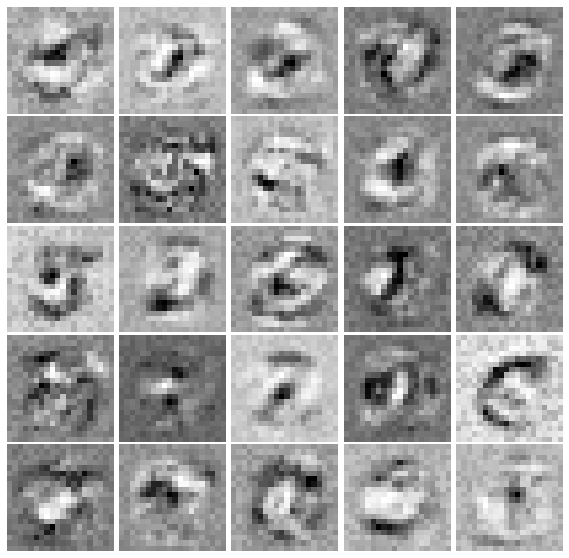

In [262]:
utils.displayData(Theta1[:, 1:])

### 3.1 Optional (ungraded) exercise

In this part of the exercise, you will get to try out different learning settings for the neural network to see how the performance of the neural network varies with the regularization parameter $\lambda$ and number of training steps (the `maxiter` option when using `scipy.optimize.minimize`). Neural networks are very powerful models that can form highly complex decision boundaries. Without regularization, it is possible for a neural network to “overfit” a training set so that it obtains close to 100% accuracy on the training set but does not as well on new examples that it has not seen before. You can set the regularization $\lambda$ to a smaller value and the `maxiter` parameter to a higher number of iterations to see this for youself.